In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd

from datetime import datetime

In [ ]:
# read geoview metadata from zip
zipfile = "zip://../data/geoview/Exploration_Reports_GDA2020_shp.zip"
geoview = gpd.read_file(zipfile)

# DATA CLEANING
geoview = geoview.loc[geoview.REPORT_YEA.notna()]
geoview.loc[geoview.REPORT_YEA == 9877, 'REPORT_YEA'] = 1977  # 9877 is invalid year - text data said 1977

In [ ]:
from datetime import datetime

# convert year as int/floats (will be float if NA's are present in column) to datetime
# DATE_TO Column has (5) NA values
geoview['year'] = geoview.REPORT_YEA.apply(lambda x : datetime.strptime(str(int(x)), '%Y'))
geoview['date_from'] = geoview.DATE_FROM.apply(lambda x: datetime.strptime(x, '%Y-%M-%d'))
geoview['date_to'] = geoview.DATE_TO.apply(lambda x: datetime.strptime(x, '%Y-%M-%d') if pd.notna(x) else pd.NaT)

# aggregate date_from and date_to into year buckets
geoview['year_from'] = geoview.date_from.map(lambda x : x.year).apply(lambda x : datetime.strptime(str(x), "%Y"))
geoview['year_to'] = geoview.date_to.map(lambda x : x.year).apply(
    lambda x : datetime.strptime(str(int(x)), "%Y") if pd.notna(x) else pd.NaT)

# date range to re-index the timseries by (so we have intermediate years that dont necessarily exist in df)
# this is required to have properly spaced timeseries in matplotlib - not sure about plotly
date_range = pd.date_range(geoview.year.min(), geoview.year.max(), freq="AS", name='year')

Visualisations to look at temporal distribution of reports in matplotlib

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# custom class used to change ticker values - we may need to implement this differently in plotly
class OffsetYearLocator(mdates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        mdates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return mdates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

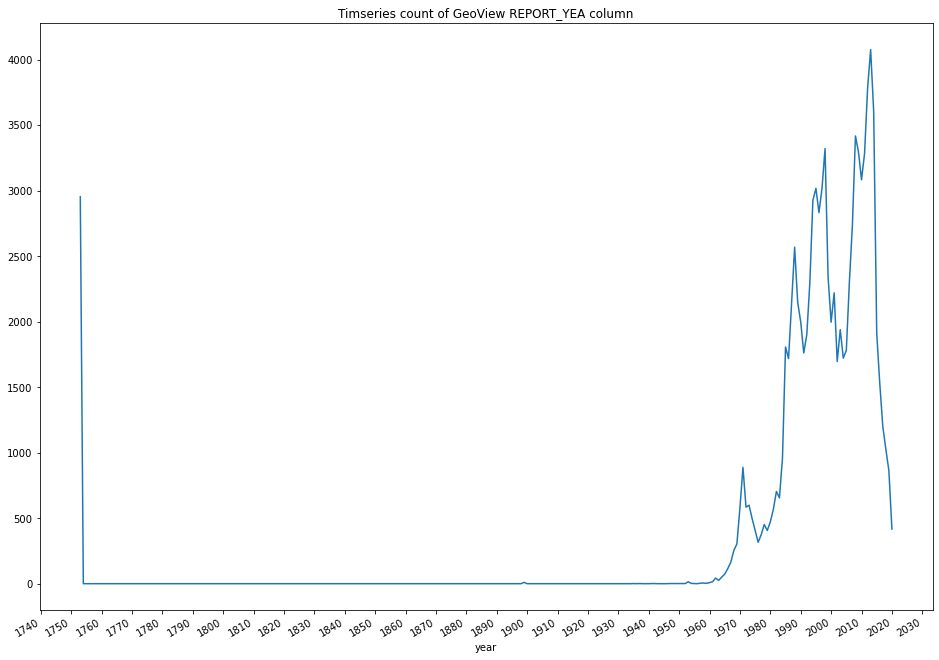

In [4]:
# view timeseries for value_counts() of each report (unique ANUMBER) for their REPORT_YEA column
fig, ax = plt.subplots(figsize=(16,12))
geoview.year.value_counts().sort_index().reindex(date_range, fill_value=0).plot(
    title = 'Timseries count of GeoView REPORT_YEA column', ax=ax, x_compat=True)

# Use custom class above to find every 10th year, then format the datetime object into year only with %Y
ax.xaxis.set_major_locator(OffsetYearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

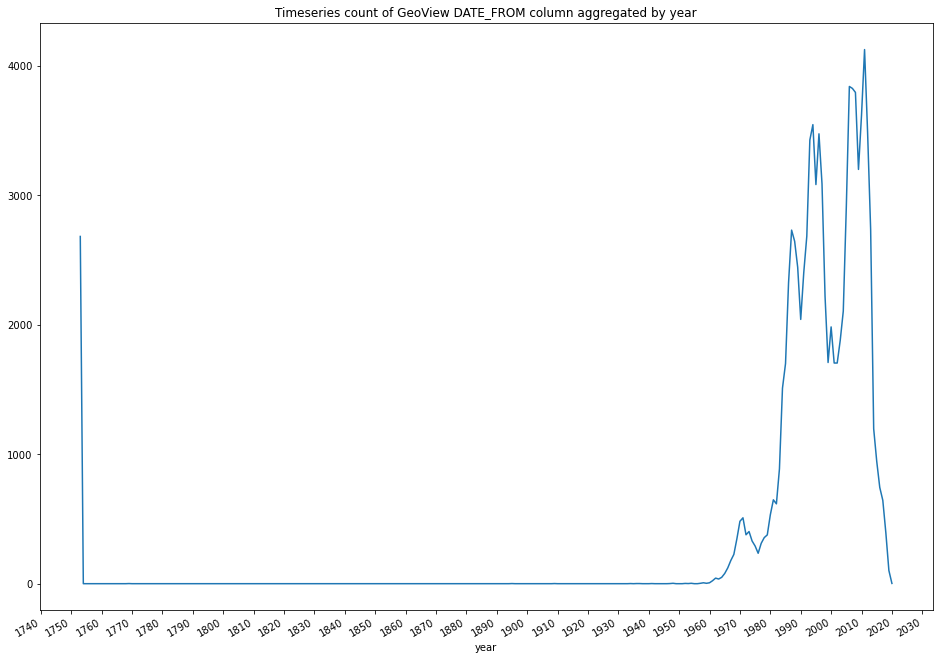

In [5]:
# view timeseries for value_counts() of each report (unique ANUMBER) for their DATE_FROM column
fig, ax = plt.subplots(figsize=(16,12))
geoview.year_from.value_counts().sort_index().reindex(date_range, fill_value=0).plot(
    title = 'Timeseries count of GeoView DATE_FROM column aggregated by year', ax=ax, x_compat=True)

# Use custom class above to find every 10th year, then format the datetime object into year only with %Y
ax.xaxis.set_major_locator(OffsetYearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

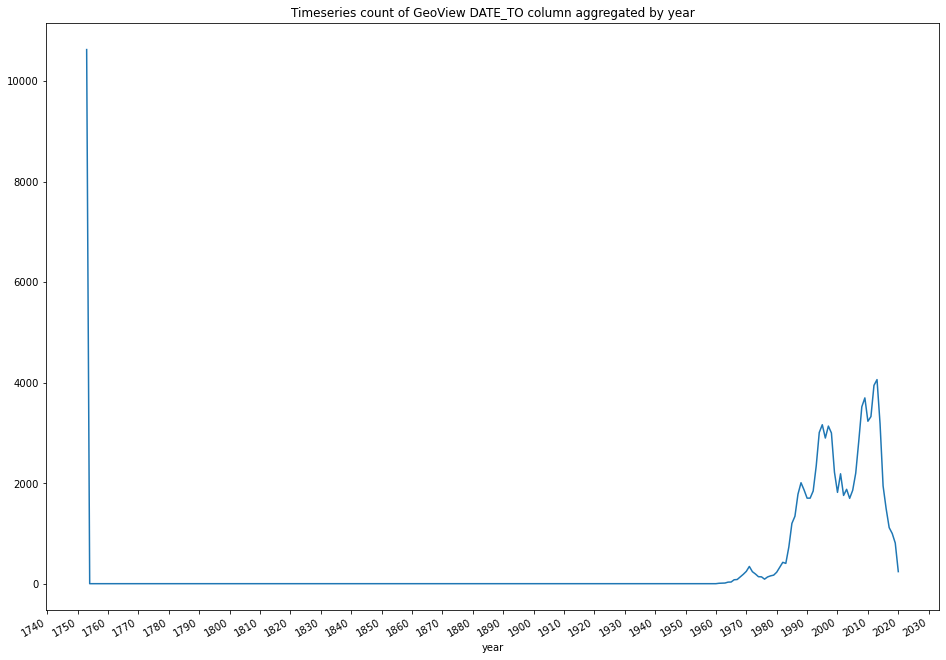

In [6]:
# view timeseries for value_counts() of each report (unique ANUMBER) for their DATE_TO column
fig, ax = plt.subplots(figsize=(16,12))
geoview.year_to.value_counts().sort_index().reindex(date_range, fill_value=0).plot(
    title = 'Timeseries count of GeoView DATE_TO column aggregated by year', ax=ax, x_compat=True)

# Use custom class above to find every 10th year, then format the datetime object into year only with %Y
ax.xaxis.set_major_locator(OffsetYearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

The `DATE_TO` column is a little strange - we should investigate if we would like to subset our data on the `REPORT_YEA`, `DATE_FROM`, or `DATE_TO` times.

My initial thought was that each dataframe could have a date "range" - e.g. assuming an exploration occured during a particular time period from `DATE_FROM = Mar 1990` to `DATE_TO = April 1992`, then if we subset the data on `DATE > 1991`, it would still pick it up.

However I think the DATE_TO data may have too many error values for this to be reasonable and we should just look at `REPORT_YEA`